# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

In [29]:
!git clone -b develop https://github.com/PetrShulzhenko/cvr_course

Cloning into 'cvr_course'...
remote: Enumerating objects: 514, done.
remote: Total 514 (delta 0), reused 0 (delta 0), pack-reused 514
Receiving objects: 100% (514/514), 64.27 MiB | 20.83 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [30]:
cd cvr_course/notebooks

/content/cvr_course/notebooks/cvr_course/notebooks


In [31]:
import numpy as np
import cv2
import glob
import time
import os
import math
import sys
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)


In [45]:
def find_contour (img, low_th, high_th):

    core = np.ones((5,5),'uint8')
    img = cv2.dilate(img,core)
    img_rgb = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.inRange (img, low_th, high_th)
    
    contours, hierarchy = cv2.findContours (mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours [0]

    approx = cv2.convexHull (cnt)

    epsilon = 0.05 * cv2.arcLength (approx, True)
    approx = cv2.approxPolyDP (approx, epsilon, True)

    return approx

def find_distance (img):
    low_th  = (200, 200, 200)
    high_th = (255, 255, 255)

    contour = find_contour (img, low_th, high_th)
    
    length = cv2.arcLength (contour, True)
    
    print (contour)

    distance = 180.0 * 364 / length
    
    return distance

10


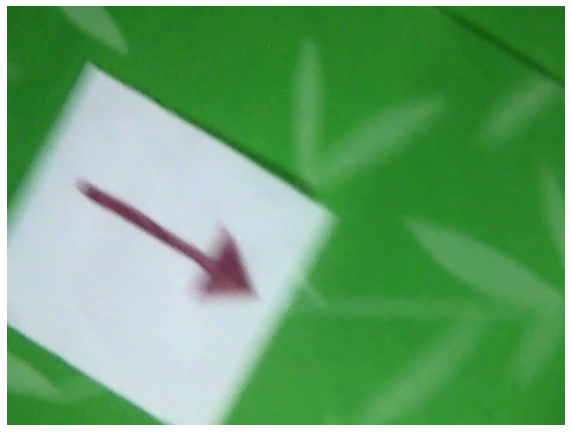

[[[ 12 320]]

 [[  8 320]]

 [[  8 316]]

 [[ 12 316]]]
4095.0


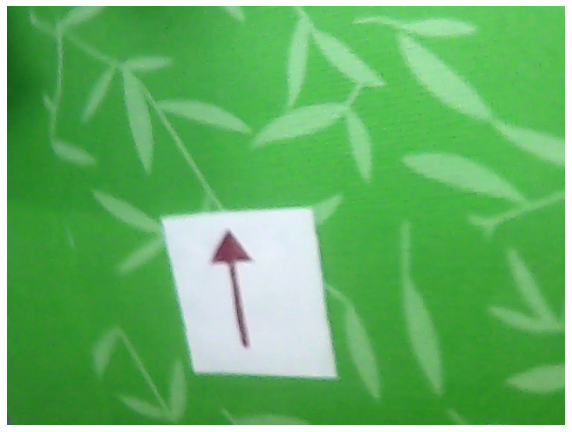

[[[375 425]]

 [[217 419]]

 [[178 244]]

 [[350 232]]]
93.0103846522249


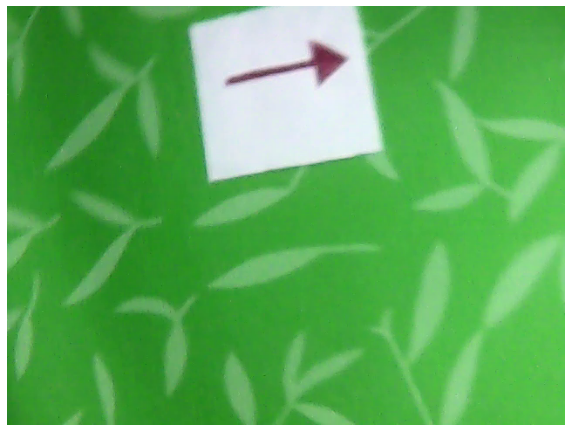

[[[429 164]]

 [[234 199]]

 [[214  26]]

 [[397   0]]]
90.4723790541648


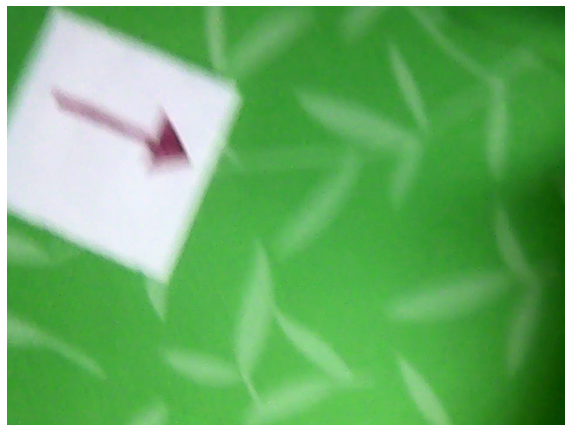

[[[259 100]]

 [[180 312]]

 [[  0 227]]

 [[ 57  16]]]
75.95340879478586


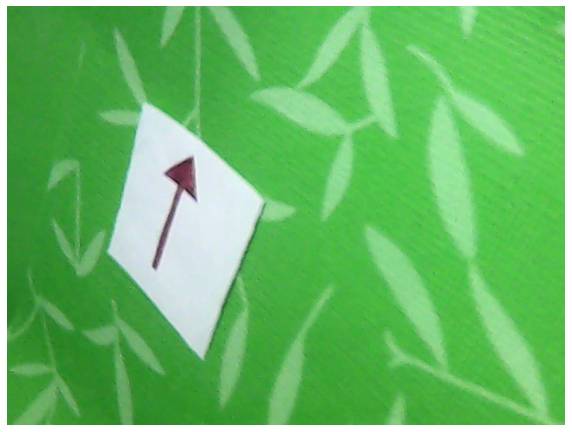

[[[157 111]]

 [[293 219]]

 [[224 402]]

 [[116 284]]]
92.67367135187634


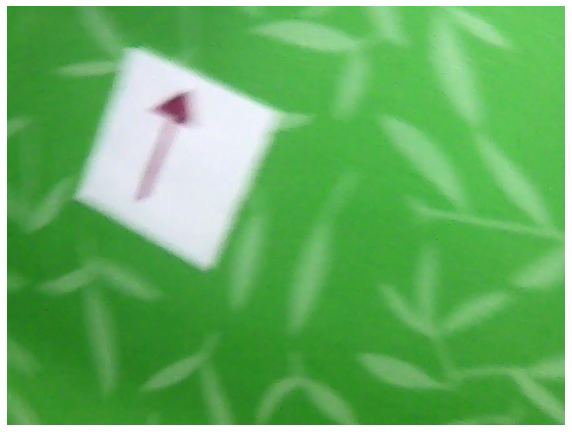

[[[309 120]]

 [[229 296]]

 [[ 88 215]]

 [[146  52]]]
92.86166041002811


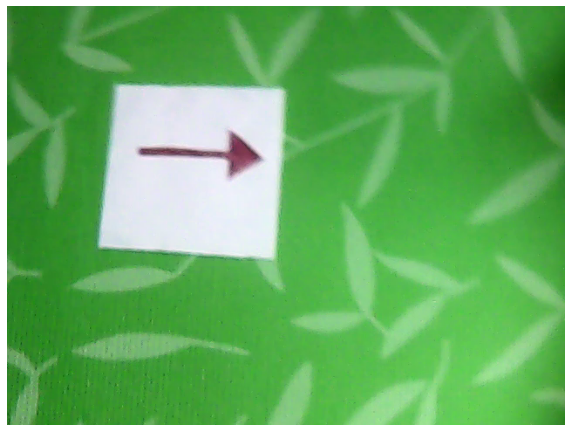

[[[317  97]]

 [[307 289]]

 [[106 275]]

 [[128  90]]]
85.18158900196393


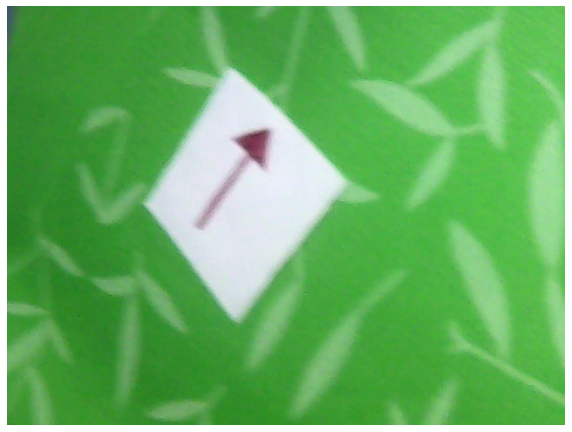

[[[388 198]]

 [[263 357]]

 [[162 231]]

 [[252  72]]]
89.52805727735729


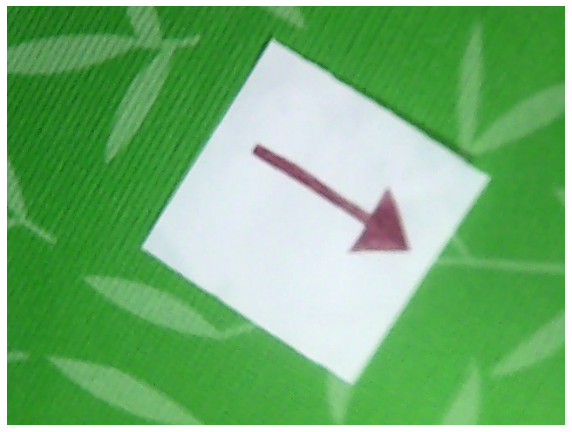

[[[549 194]]

 [[396 432]]

 [[156 279]]

 [[301  40]]]
57.52273530686937


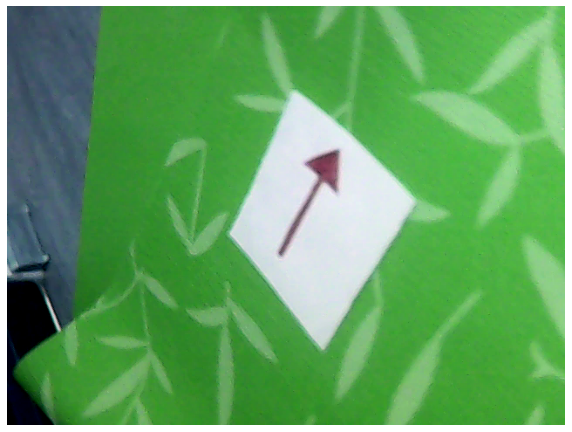

[[[ 61 371]]

 [[ 44 336]]]
841.9396468433578


In [46]:
images = glob.glob('../data/imgs/arrow/*.png')
print(len(images))
for fname in images:
  img = cv2.imread(fname)
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  
  dist = find_distance(img)
  print(dist)

In [47]:

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
  
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return warped
    

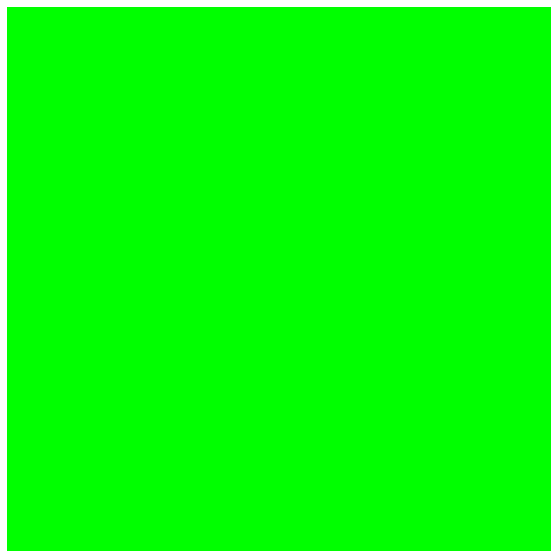

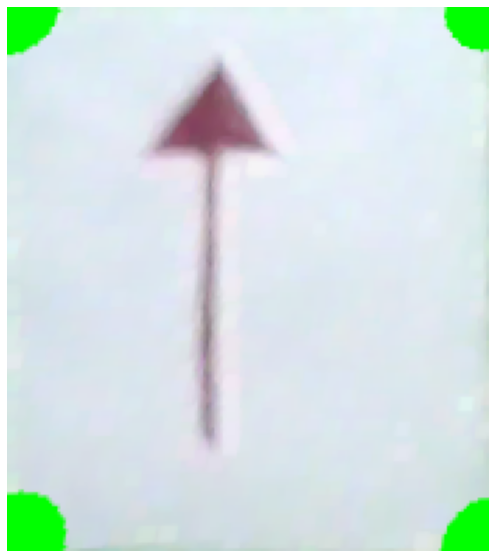

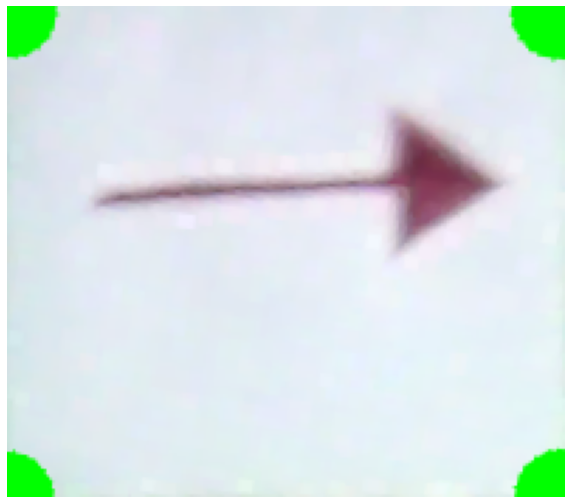

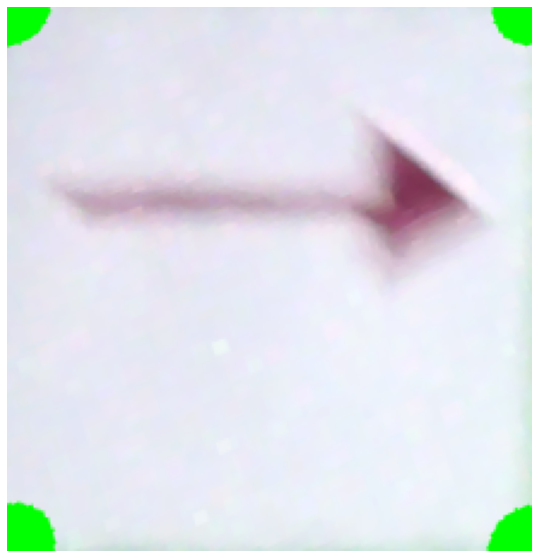

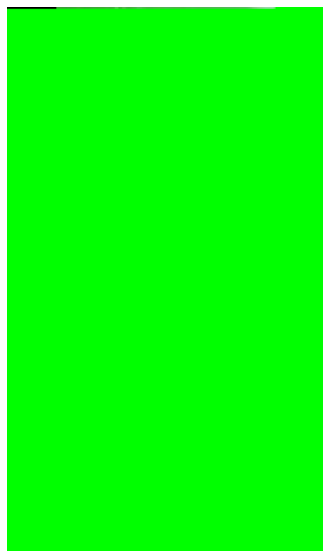

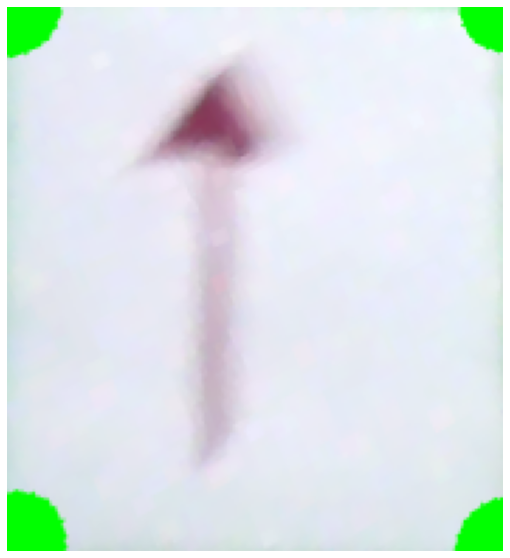

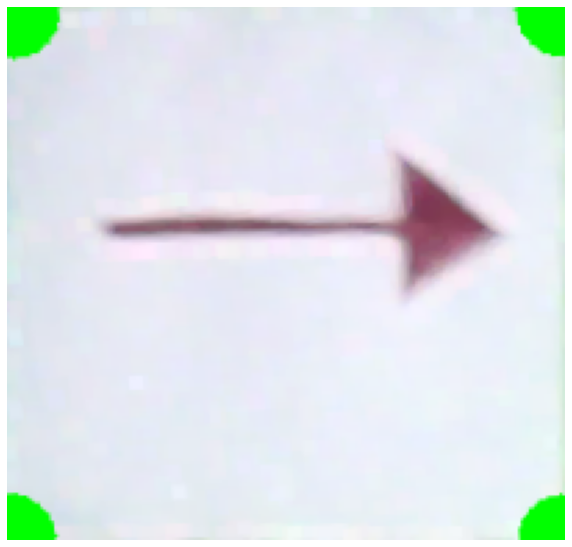

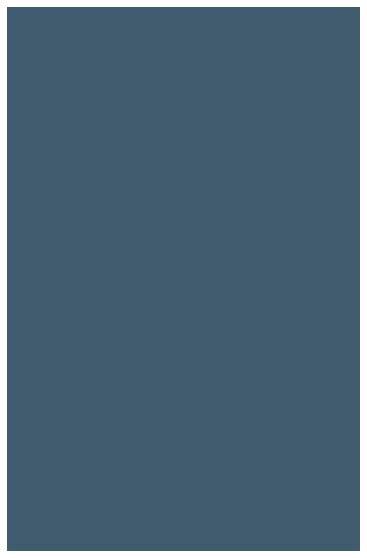

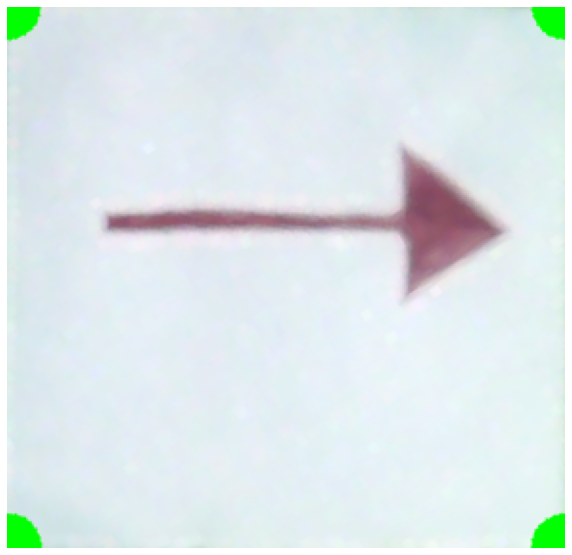

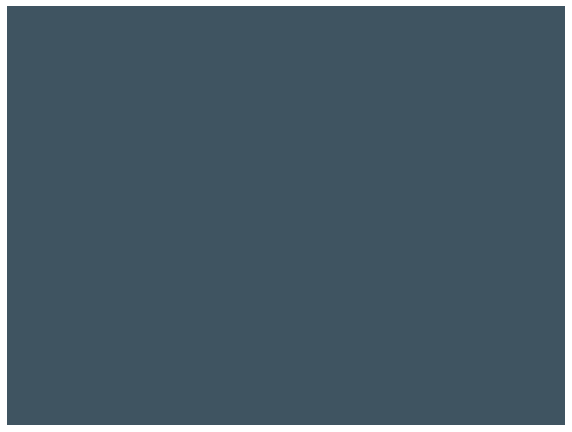

In [52]:
images = glob.glob('../data/imgs/arrow/*.png')
low_th  = (200, 200, 200)
high_th = (255, 255, 255)
for fname in images:
  img = cv2.imread(fname)
  core = np.ones((5,5),'uint8')
  img = cv2.dilate(img,core)

  mask = cv2.inRange (img, low_th, high_th)
  
  contours, hierarchy = cv2.findContours (mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnt = contours [0]

  approx = cv2.convexHull (cnt)

  epsilon = 0.05 * cv2.arcLength (approx, True)

  approx = cv2.approxPolyDP (approx, epsilon, True)

  contour_marked = cv2.drawContours (img, approx, -1, (0, 255, 0), 33)

  #plt.imshow (contour_marked)
  #plt.axis ('off')
  #plt.show ()

  warped = four_point_transform (img, np.asarray (approx) [:, 0, :])

  plt.imshow (warped)
  plt.axis ('off')
  plt.show ()

# Новый раздел